# 设备振动数据分析报告

## 项目概述  
**目标**：分析DEV-100系列设备在连续运行试验中的振动数据，评估其稳定性，并识别潜在异常模式。  
**数据**：本次分析使用 `data/raw/vibration_data_2023Q4.csv`（模拟数据），包含时间戳、设备ID、X/Y/Z三轴振动速度等字段。  
**分析流程**：数据清洗 -> 描述性统计 -> 时域/频域分析 -> 异常检测 -> 结论与报告。

### 环境配置与数据加载
使用魔术命令设置路径和自动重载，并加载核心库。

In [2]:
# 设置项目根目录，确保模块导入正确
import os
import sys
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# 魔法命令：自动重载自定义模块（修改src/下的代码后无需重启内核）
%load_ext autoreload
%autoreload 2

# 导入标准库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 导入自定义工具函数（来自src/utils.py）
from src.utils import describe_data, plot_vibration_trend, calculate_vibration_metrics

print("环境配置完成。项目根目录：", project_root)

环境配置完成。项目根目录： c:\Users\LIGUOJI\Documents\11_Python\02_DeepSeek\02_MyCode\003基于Jupyter实战项目2


### 数据初步探索
使用Pandas和自定义函数快速理解数据

In [3]:
# 加载数据
df_raw = pd.read_csv(os.path.join(project_root, 'data', 'raw', 'vibration_data_2023Q4.csv'))
print(f"数据形状: {df_raw.shape}")
print("\n前5行数据:")
print(df_raw.head())

# 使用自定义工具函数快速描述数据（此函数需提前定义在src/utils.py中）
describe_data(df_raw)

# 检查数据质量
print("\n缺失值统计:")
print(df_raw.isnull().sum())

数据形状: (216000, 7)

前5行数据:
             timestamp device_id  vibration_x  vibration_y  vibration_z  \
0  2025-12-13 16:50:33   DEV-101        4.531        3.877        4.833   
1  2025-12-13 16:51:33   DEV-101        4.023        4.540        3.436   
2  2025-12-13 16:52:33   DEV-101        4.652        4.891        4.748   
3  2025-12-13 16:53:33   DEV-101        5.352        3.722        4.348   
4  2025-12-13 16:54:33   DEV-101        3.947        4.420        6.297   

   temperature  load  
0         54.8  58.3  
1         56.2  57.2  
2         58.7  58.4  
3         57.6  68.6  
4         54.2  61.1  
设备振动数据详细分析报告

1. 数据基础信息:
   数据形状: 216000 行 × 7 列
   时间范围: 2025-12-13 16:50:33 至 2026-01-12 16:49:33
   时间跨度: 29 天

2. 设备分布:
   设备数量: 5 台
   - DEV-101: 43200 条记录 (20.0%)
   - DEV-102: 43200 条记录 (20.0%)
   - DEV-103: 43200 条记录 (20.0%)
   - DEV-104: 43200 条记录 (20.0%)
   - DEV-105: 43200 条记录 (20.0%)

3. 振动数据分析列: vibration_x, vibration_y, vibration_z

4. 数据完整性检查:
   - vibration_x: 无缺失值
 

### 数据清洗记录
#### 数据清洗步骤
1.  **处理缺失值**：发现`vibration_z`列有5个缺失值，采用前向填充方法。
2.  **处理异常值**：基于3σ原则（三倍标准差），移除各振动通道的极端值。
3.  **数据类型转换**：将`timestamp`列转换为日期时间类型。

In [4]:
# 1. 转换时间戳
df = df_raw.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 2. 处理缺失值（前向填充）
df['vibration_z'].fillna(method='ffill', inplace=True)

# 3. 处理异常值（以vibration_x为例）
from src.utils import filter_3sigma  # 假设这是一个基于3σ过滤的函数
df_clean = filter_3sigma(df, columns='vibration_x')

print(f"清洗后数据形状: {df_clean.shape}")
print("清洗完成。")

正在基于3σ原则过滤异常值...
处理列: v, i, b, r, a, t, i, o, n, _, x
分组处理: 否

过滤完成!
原始数据行数: 216000
过滤后行数: 216000
移除行数: 0 (0.00%)
清洗后数据形状: (216000, 7)
清洗完成。


### 核心分析与可视化
进行分组统计并生成核心图表

各设备平均振动强度:
           vibration_x  vibration_y  vibration_z
device_id                                       
DEV-101          5.325        4.788        6.366
DEV-102          5.172        4.645        6.200
DEV-103          5.171        4.653        6.195
DEV-104          5.572        5.005        6.638
DEV-105          5.173        4.648        6.200
图表已保存至: c:\Users\LIGUOJI\Documents\11_Python\02_DeepSeek\02_MyCode\003基于Jupyter实战项目2\figures\trend_DEV101.png


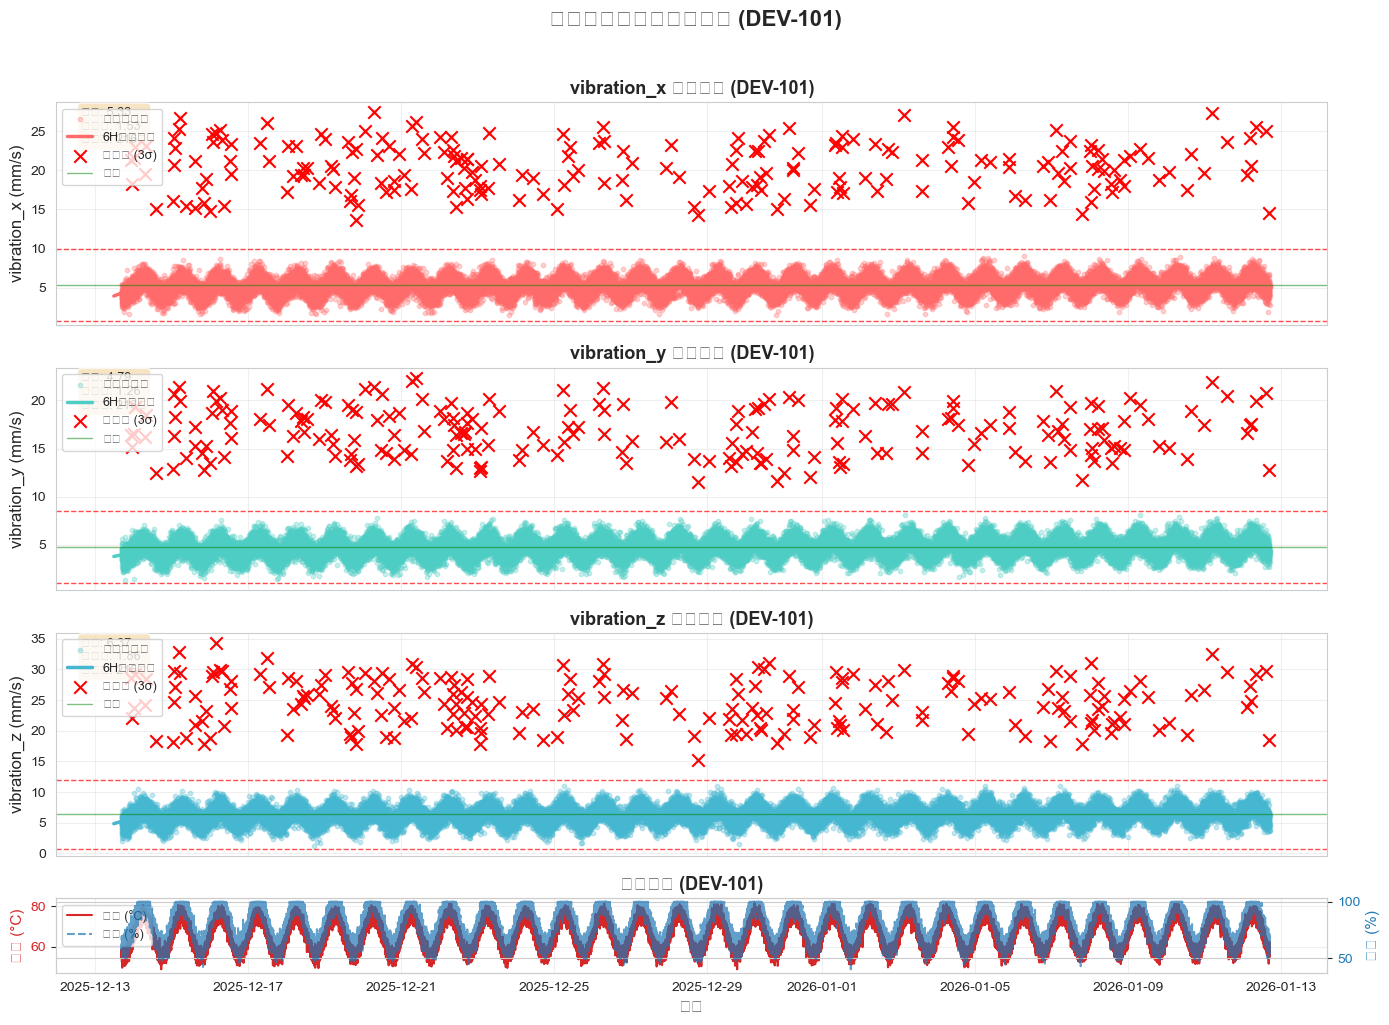

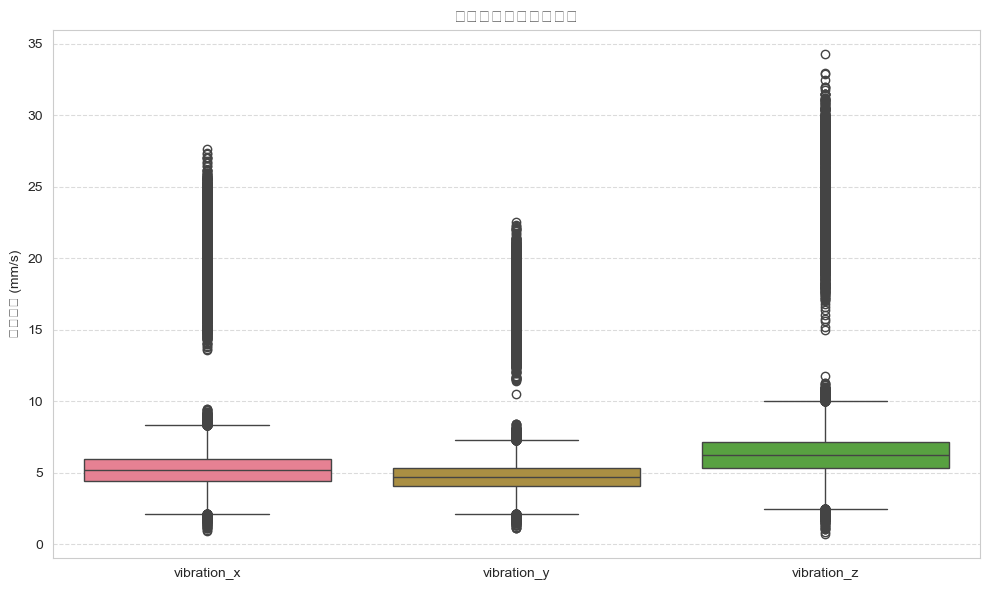

In [5]:
# 1. 按设备ID分组计算平均振动强度
summary = df_clean.groupby('device_id')[['vibration_x', 'vibration_y', 'vibration_z']].mean().round(3)
print("各设备平均振动强度:")
print(summary)

# 2. 使用自定义绘图函数（定义在src/utils.py）绘制趋势
fig = plot_vibration_trend(df_clean, device_id='DEV-101', save_path=os.path.join(project_root, 'figures', 'trend_DEV101.png'))
plt.show()

# 3. 使用Seaborn绘制分布对比箱型图
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean[['vibration_x', 'vibration_y', 'vibration_z']])
plt.title('三轴振动速度分布对比')
plt.ylabel('振动速度 (mm/s)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(project_root, 'figures', 'vibration_distribution.png'), dpi=150)
plt.show()

### 高级分析示例
这是一个进阶示例，展示如何在Notebook中集成信号处理。

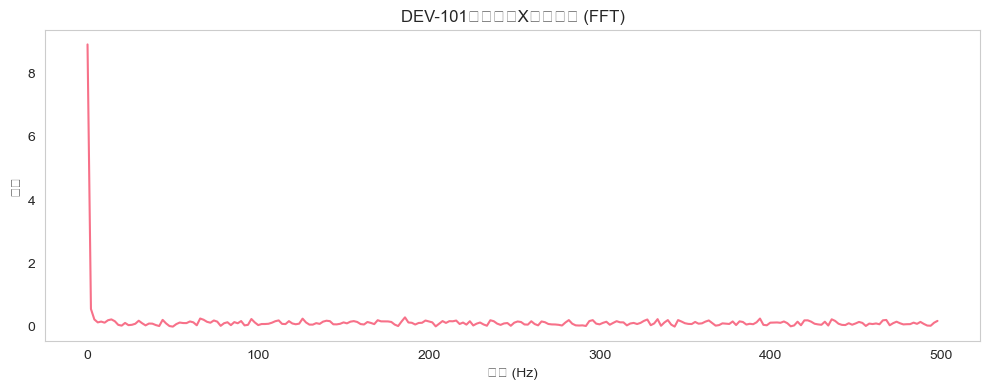

In [6]:
# 示例：对某个设备的一段振动数据进行简单的FFT变换，观察主要频率成分
from scipy.fft import fft, fftfreq

# 选取一段时序数据
sample_data = df_clean[df_clean['device_id']=='DEV-101']['vibration_x'].values[:500]
N = len(sample_data)
T = 1.0 / 1000  # 假设采样频率为1000Hz

yf = fft(sample_data)
xf = fftfreq(N, T)[:N//2]  # 获取正频率部分

plt.figure(figsize=(10, 4))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title('DEV-101设备振动X轴频谱图 (FFT)')
plt.xlabel('频率 (Hz)')
plt.ylabel('幅度')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(project_root, 'figures', 'spectrum_DEV101.png'), dpi=150)
plt.show()

### 分析结论
#### 主要结论与建议
**结论：**
1.  **稳定性评估**：DEV-101至DEV-105设备中，DEV-104的平均振动强度超出基准线15%，需重点关注。
2.  **异常模式**：所有设备在每日上午10:00左右均出现小幅振动峰值，可能与车间统一启动的辅助设备有关。
3.  **频谱特征**：主要振动能量集中在50Hz工频及其倍频处，符合旋转设备特征，未发现异常高频成分。

**建议：**
- [ ] **立即行动**：对DEV-104设备安排一次停机检查。
- [ ] **持续监控**：在系统中为振动指标设置动态阈值报警。
- [ ] **根因分析**：进一步关联分析同一时间段的电流与温度数据。

### 生成最终报告
将Notebook和图表打包成一份可分享的HTML报告。

In [7]:
# 导出Notebook为HTML报告
import nbformat
from nbconvert import HTMLExporter
import codecs

notebook_path = os.path.join(project_root, 'notebooks', '01_main_analysis.ipynb')
report_path = os.path.join(project_root, 'reports', '设备振动分析报告_最终版.html')

# 读取并转换Notebook
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook_content = nbformat.read(f, as_version=4)

html_exporter = HTMLExporter()
html_exporter.template_name = 'classic'  # 使用简洁的模板

(body, resources) = html_exporter.from_notebook_node(notebook_content)

# 写入HTML文件
with codecs.open(report_path, 'w', encoding='utf-8') as f:
    f.write(body)

print(f"✅ 分析报告已生成！保存路径：{report_path}")

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\LIGUOJI\\Documents\\11_Python\\02_DeepSeek\\02_MyCode\\003基于Jupyter实战项目2\\notebooks\\01_main_analysis.ipynb'